In [28]:
%load_ext autoreload

In [29]:
%autoreload 2
from collections import defaultdict
from datetime import datetime
import h5py
import matplotlib.pyplot as plt
from neural_analysis.matIO import loadmat
import numpy as np
import os
import pandas as pd
from scipy.signal import butter, filtfilt, freqz
from scipy.stats import pearsonr
from statsmodels.tsa import stattools
import sys
import time
from tqdm.auto import tqdm

sys.path.append('../../..')
from ld_utils import compute_eigs, get_data_sigma_norms
from up_down import get_up_down
from utils import get_binary_stimuli, get_sample_interval, load, save, to_string

## Load Neural Data

In [3]:
session = 'Mary-Anesthesia-20160809-01'
# session = 'MrJones-Anesthesia-20160113-01.mat'
# filename = fr'/home/adameisen/millerdata/common/datasets/anesthesia/mat/propofolPuffTone/{session}.mat'
filename = fr'/om/user/eisenaj/ChaoticConsciousness/data/propofolPuffTone/{session}.mat'
print("Loading data ...")
start = time.process_time()
electrode_info, lfp, lfp_schema, session_info, spike_times, unit_info = loadmat(filename, variables=['electrodeInfo', 'lfp', 'lfpSchema', 'sessionInfo', 'spikeTimes', 'unitInfo'], verbose=False)
spike_times = spike_times[0]
dt = lfp_schema['smpInterval'][0]
T = lfp.shape[0]

# f = h5py.File(filename, 'r')
# airPuff_binary, audio_binary = get_binary_stimuli(f)

print(f"Data loaded (took {time.process_time() - start:.2f} seconds)")

Loading data ...
Data loaded (took 142.41 seconds)


# Correlations

In [111]:
t = time.localtime()
timestamp = time.strftime('%b-%d-%Y_%H%M', t)
data_path = f"/om/user/eisenaj/ChaoticConsciousness/results/propofol/correlations"
os.makedirs(data_path, exist_ok=True)

PCA_dim = -1
end_step = T - int(30/dt) # take off 30 seconds

# end_step = 15000
# for window in [2.5]:
# for window in [0.15, 0.25, 0.5, 1, 2.5, 5]:
for window in [2.5]:
    stride = window, 
#     stride = 10
    run_data = {}
    
    # ================
    # RUN PARAMS
    # ================
    run_data['run_params'] = dict(
        window=window,
        stride=stride,
        PCA_dim=PCA_dim,
        end_step=end_step,
        unit_indices={}
    )
    
    run_data['results'] = {}
    
    # ================
    # ALL AREAS
    # ================
    
    print(f"window = {window}, all areas")
    areas = np.unique(electrode_info['area'])
    unit_indices = np.arange(lfp.shape[1])[pd.Series(electrode_info['area']).isin(areas)]
    data = lfp[:end_step, unit_indices]
    
    results = {}
    
    lags = [4]
    p = 4
    run_data['run_params']['p'] = p
    num_windows = int(end_step/int(stride/dt))
    results['causality'] = np.zeros((num_windows, len(unit_indices), len(unit_indices)))
    for i in tqdm(range(num_windows)):
        window_data = data[int(stride/dt)*i:int(stride/dt)*i + int(window/dt)]
        for j, unit1 in tqdm(enumerate(unit_indices), total=len(unit_indices)):
            for k, unit2 in enumerate(unit_indices):
                grangers = stattools.grangercausalitytests(window_data[:, [unit2, unit1]], lags, verbose=False)
                true_vals = grangers[p][1][0].model.data.endog
                restricted_preds = grangers[p][1][0].model.data.exog @ grangers[p][1][0].params
                unrestricted_preds = grangers[p][1][1].model.data.exog @ grangers[p][1][1].params
                restricted_error = true_vals - restricted_preds
                unrestricted_error = true_vals - unrestricted_preds
                results['causality'][i, j, k] = np.log(np.var(restricted_error)/np.var(unrestricted_error))
    
        break
    run_data['results']['all'] = results
    run_data['run_params']['unit_indices']['all'] = unit_indices

    save(run_data, os.path.join(data_path, f"correlations_{os.path.basename(filename)[:-4]}_window_{window}_stride_{stride}_{timestamp}"))

window = 2.5, all areas


  0%|          | 0/2822 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

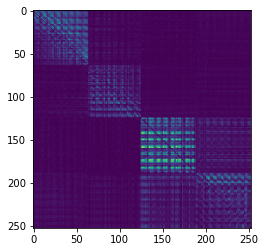

In [114]:
plt.imshow(results['causality'][0])

In [115]:
electrode_info['area']

array(['vlPFC', 'vlPFC', 'vlPFC', 'vlPFC', 'vlPFC', 'vlPFC', 'vlPFC',
       'vlPFC', 'vlPFC', 'vlPFC', 'vlPFC', 'vlPFC', 'vlPFC', 'vlPFC',
       'vlPFC', 'vlPFC', 'vlPFC', 'vlPFC', 'vlPFC', 'vlPFC', 'vlPFC',
       'vlPFC', 'vlPFC', 'vlPFC', 'vlPFC', 'vlPFC', 'vlPFC', 'vlPFC',
       'vlPFC', 'vlPFC', 'vlPFC', 'vlPFC', 'vlPFC', 'vlPFC', 'vlPFC',
       'vlPFC', 'vlPFC', 'vlPFC', 'vlPFC', 'vlPFC', 'vlPFC', 'vlPFC',
       'vlPFC', 'vlPFC', 'vlPFC', 'vlPFC', 'vlPFC', 'vlPFC', 'vlPFC',
       'vlPFC', 'vlPFC', 'vlPFC', 'vlPFC', 'vlPFC', 'vlPFC', 'vlPFC',
       'vlPFC', 'vlPFC', 'vlPFC', 'vlPFC', 'vlPFC', 'vlPFC', 'vlPFC',
       'vlPFC', 'FEF', 'FEF', 'FEF', 'FEF', 'FEF', 'FEF', 'FEF', 'FEF',
       'FEF', 'FEF', 'FEF', 'FEF', 'FEF', 'FEF', 'FEF', 'FEF', 'FEF',
       'FEF', 'FEF', 'FEF', 'FEF', 'FEF', 'FEF', 'FEF', 'FEF', 'FEF',
       'FEF', 'FEF', 'FEF', 'FEF', 'FEF', 'FEF', 'FEF', 'FEF', 'FEF',
       'FEF', 'FEF', 'FEF', 'FEF', 'FEF', 'FEF', 'FEF', 'FEF', 'FEF',
       'FEF', 'FEF

# Messing Around with Causality

In [97]:
lags = 10
grangers = stattools.grangercausalitytests(window_data[:, [0, 1]], lags, verbose=False)

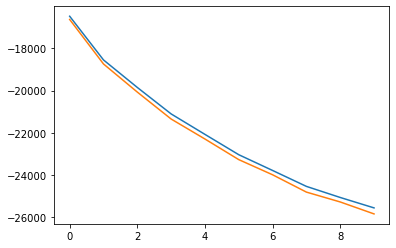

In [98]:
restricted_aic = [grangers[p][1][0].aic for p in range(1, lags+1)]
unrestricted_aic = [grangers[p][1][1].aic for p in range(1, lags+1)]
plt.plot(restricted_aic, label='restricted AIC')
plt.plot(unrestricted_aic, label='unrestricted AIC')
plt.show()

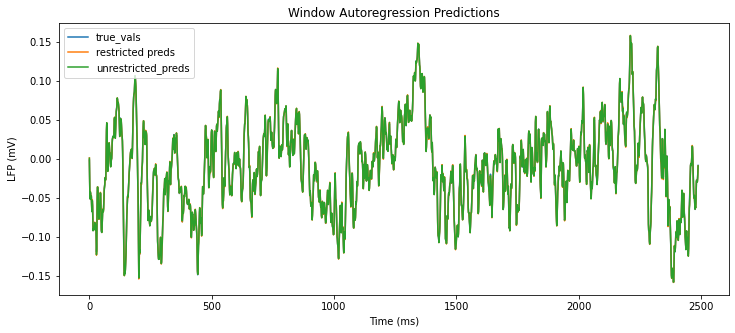

In [99]:
p = 10
plt.figure(figsize=(12, 5))
true_vals = grangers[p][1][0].model.data.endog
restricted_preds = grangers[p][1][0].model.data.exog @ grangers[p][1][0].params
unrestricted_preds = grangers[p][1][1].model.data.exog @ grangers[p][1][1].params
plt.plot(true_vals, label='true_vals')
plt.plot(restricted_preds, label='restricted preds')
plt.plot(unrestricted_preds, label='unrestricted_preds')
plt.legend()
plt.xlabel('Time (ms)')
plt.ylabel('LFP (mV)')
plt.title("Window Autoregression Predictions")
plt.show()

In [101]:
restricted_error = true_vals - restricted_preds
unrestricted_error = true_vals - unrestricted_preds

In [104]:
np.log(np.var(restricted_error)/np.var(unrestricted_error))

0.12281090547887208

# Testing Out

In [24]:
session = "Mary-Anesthesia-20160809-01"
window = 2.5
stride = 2.5
data_dir = f"/om/user/eisenaj/ChaoticConsciousness/data/propofolPuffTone/{session}_window_{window}_stride_{stride}"

In [31]:
files = os.listdir(data_dir)
file_path = os.path.join(data_dir, files[0])

In [35]:
import queue
message_queue = None

In [36]:
# if message_queue is not None:
    # message_queue.put((worker_name, "starting up !!"))
while True:
    try:
        1/0
#         file_path, results_dir = task_queue.get_nowait()
        window_data = load(file_path)

        num_units = window_data['data'].shape[1]

        if task_type == 'causality':
            window_data['causality'] = np.zeros((num_units, num_units))

            lags = [2]
            p = 2
            for i in range(num_units):
                for j in range(num_units):
                    grangers = stattools.grangercausalitytests(window_data['data'][:, [j, i]], lags, verbose=False)
                    true_vals = grangers[p][1][0].model.data.endog
                    restricted_preds = grangers[p][1][0].model.data.exog @ grangers[p][1][0].params
                    unrestricted_preds = grangers[p][1][1].model.data.exog @ grangers[p][1][1].params
                    restricted_error = true_vals - restricted_preds
                    unrestricted_error = true_vals - unrestricted_preds
                    window_data['causality'][i, j] = np.log(np.var(restricted_error)/np.var(unrestricted_error))

                message_queue.put((worker_name, f"completed {i+1} units"))
        else: # task_type == 'correlations'
            window_data['correlations'] = np.zeros((num_units, num_units))
            window_data['p_vals'] = np.zeros((num_units, num_units))

            for i in range(num_units):
                for j in range(num_units):
                    window_data['correlations'][i, j], window_data['p_vals'][i, j] = pearsonr(window_data['data'][:, i], window_data['data'][:, j])

        del window_data['data']
        save(window_data, os.path.join(results_dir, os.path.basename(file_path)))

        if message_queue is not None:
            message_queue.put((worker_name, 'task complete'))

        task_queue.task_done()

    except queue.Empty:
        if message_queue is not None:
            message_queue.put((worker_name, "shutting down..."))
        # message_queue.put((worker_name, "EMPTY"))
        break
    except:
        tb = traceback.format_exc()
        if message_queue is not None:
            message_queue.put((worker_name, tb))
        break

In [38]:
print(tb)

Traceback (most recent call last):
  File "/tmp/ipykernel_2231/2501785727.py", line 5, in <module>
    1/0
ZeroDivisionError: division by zero

